In [1]:
import os
import mlflow
import optuna
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from copy import deepcopy
from pathlib import Path
from dotenv import load_dotenv
import sys
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import linregress
import powerlaw
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from scipy.stats import norm, entropy, gamma



from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.outliers import ArbitraryOutlierCapper
from feature_engine.timeseries.forecasting import WindowFeatures
import matplotlib
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 8.5

pd.set_option('display.max_columns', None)
# If you want to revert back to the default behavior:
# pd.reset_option('display.max_columns')

/home/marcos/miniconda3/envs/vfm_3wdataset/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Load and Preprocess Data**

In [2]:
def process_metadata(dir_path, folder_classes=['3', '0'], file_format='.csv'):
    
    addresses, instances, events, y = [], [], [], []
    for root, _, files in os.walk(dir_path):
        
        # last name in the folder path is the class
        event = os.path.basename(root)
        if event in folder_classes:
            for file in files:
                if file.endswith(file_format):
                    address = os.path.join(root, file)
                    instance = file.split('.')[0]
                    
                    if len(folder_classes) == 2:
                        positive_class = folder_classes[0]
                        y_ = 1 if event == positive_class else 0
                    else:
                        y_ = event
                    addresses.append(address)
                    instances.append(instance)
                    events.append(event)
                    y.append(y_)
                    
    sorted_data = sorted(zip(addresses, instances, events, y), key=lambda item: item[0])
    addresses, instances, events, y = map(list, zip(*sorted_data))
    return addresses, instances, events, y

dir_path = os.path.expanduser('~/Github/3w_petrobras/data')
addresses, instances, events, y = process_metadata(dir_path, ['3', '4'])

In [3]:
addresses_train, addresses_test, instances_train, \
instances_test, events_train, events_test,\
y_train, y_test = train_test_split(
    addresses, instances, events, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

data_instances_info = np.column_stack(
    [
        np.concatenate([addresses_train, addresses_test], axis=0),
        np.concatenate([instances_train, instances_test], axis=0),
        np.concatenate([events_train, events_test], axis=0),
        np.concatenate([y_train, y_test], axis=0),
        np.concatenate([['Train']*len(y_train), ['Test']*len(y_test)])
    ]
)

df_metadata = pd.DataFrame(data=data_instances_info, columns=['Address', 'Instance', 'Event', 'Class', 'Set'])
df_metadata['id'] = np.arange(df_metadata.shape[0])
df_metadata.head()

,Address,Instance,Event,Class,Set,id
0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train,0
1,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00002_20131215000010,4,0,Train,1
2,/home/marcos/Github/3w_petrobras/data/3/WELL-0...,WELL-00014_20170925010031,3,1,Train,2
3,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00002_20140126060141,4,0,Train,3
4,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00004_20141118070038,4,0,Train,4


In [4]:
def preprocess(df,instance, periods_undersample = None, positive_event = None):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.index = df['timestamp']
    df = df.drop(columns=['timestamp'])
                

    df = df.ffill().bfill()

    if positive_event is not None:
        df['class'] = df['class'].apply(lambda x: positive_event in str(x)).astype(int)
    
    for col in df.columns:
        if col != 'class': 
            df[f"{col}__is_missing"] = 1 if df.isna().sum()[col] == df.shape[0] else 0

    df['is_simulated'] = int('SIMULATED' in instance)
    df['is_well'] = int('WELL' in instance)
    #df['is_drawn'] = int('DRAWN' in instance)
    
    df = df.fillna(0)

    if type(periods_undersample) in [int, str]:
        if type(periods_undersample) == int:
            periods_undersample = f'{periods_undersample}s'  
            
        df = df.resample(periods_undersample).last() 
        
    df = df.reset_index()
    return df
    

def preprocess_all(df_metadata, periods_undersample, positive_event):
    addresses = df_metadata['Address'].tolist()
    ids = df_metadata['id'].tolist()
    instances = df_metadata['Instance'].tolist()
    df_list = []

    for address, id_, instance in zip(addresses, ids, instances):
        df = preprocess(pd.read_csv(address), instance, periods_undersample, positive_event)
        
        df['id'] = id_
        df_list.append(df)
    
    df = pd.concat(df_list, axis=0)
    df = df.merge(df_metadata, on='id', how='left').set_index('timestamp')
    
    return df

df_all = preprocess_all(df_metadata, periods_undersample=60, positive_event='3')
display(df_all.head())

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,P-PDG__is_missing,P-TPT__is_missing,T-TPT__is_missing,P-MON-CKP__is_missing,T-JUS-CKP__is_missing,P-JUS-CKGL__is_missing,T-JUS-CKGL__is_missing,QGL__is_missing,is_simulated,is_well,id,Address,Instance,Event,Class,Set
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-26 07:00:00,0.0,20748600.0,106.0458,11581800.0,65.95757,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,1,0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train
2017-06-26 07:01:00,0.0,20789970.0,106.0773,11804980.0,66.67235,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,1,0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train
2017-06-26 07:02:00,0.0,20817550.0,106.0278,11747860.0,67.24754,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,1,0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train
2017-06-26 07:03:00,0.0,20812950.0,106.0278,11694530.0,67.16225,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,1,0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train
2017-06-26 07:04:00,0.0,20787670.0,106.0323,11601420.0,66.89703,0.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,1,0,/home/marcos/Github/3w_petrobras/data/4/WELL-0...,WELL-00005_20170626070033,4,0,Train


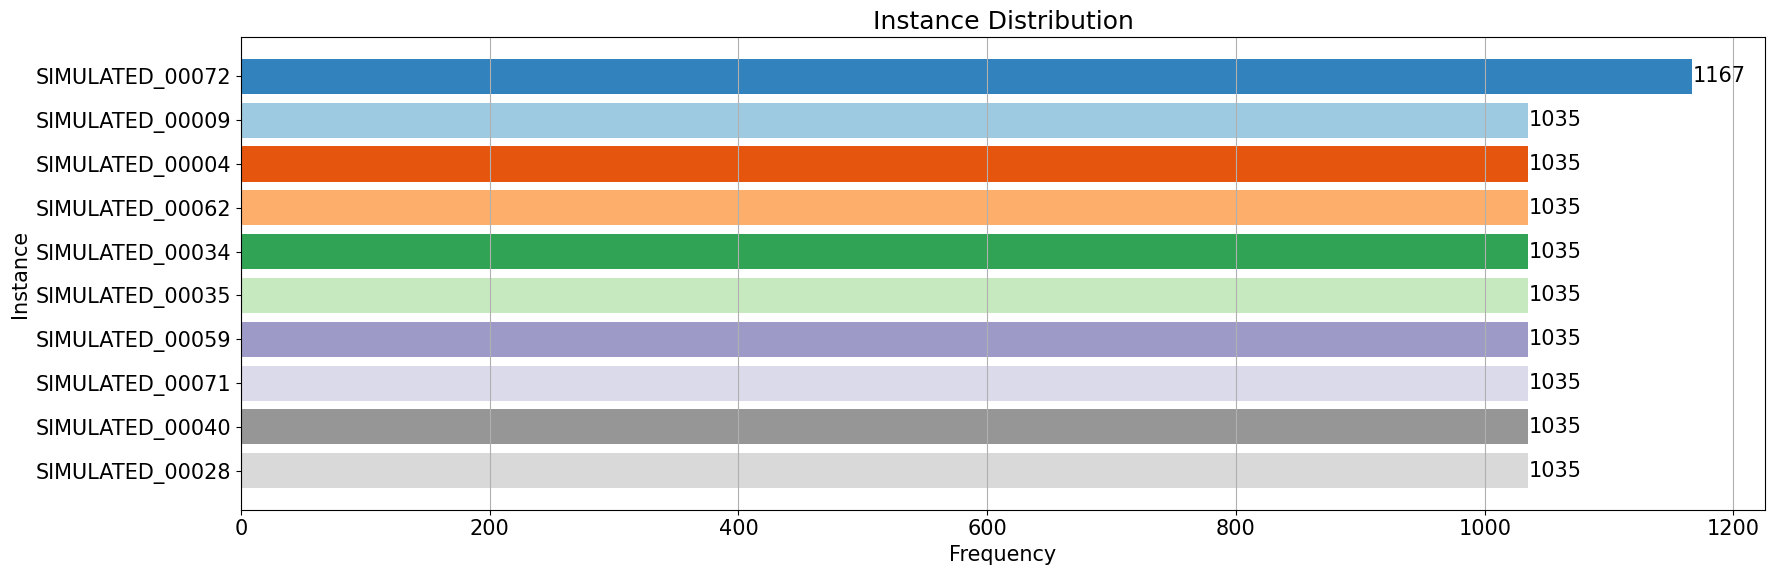

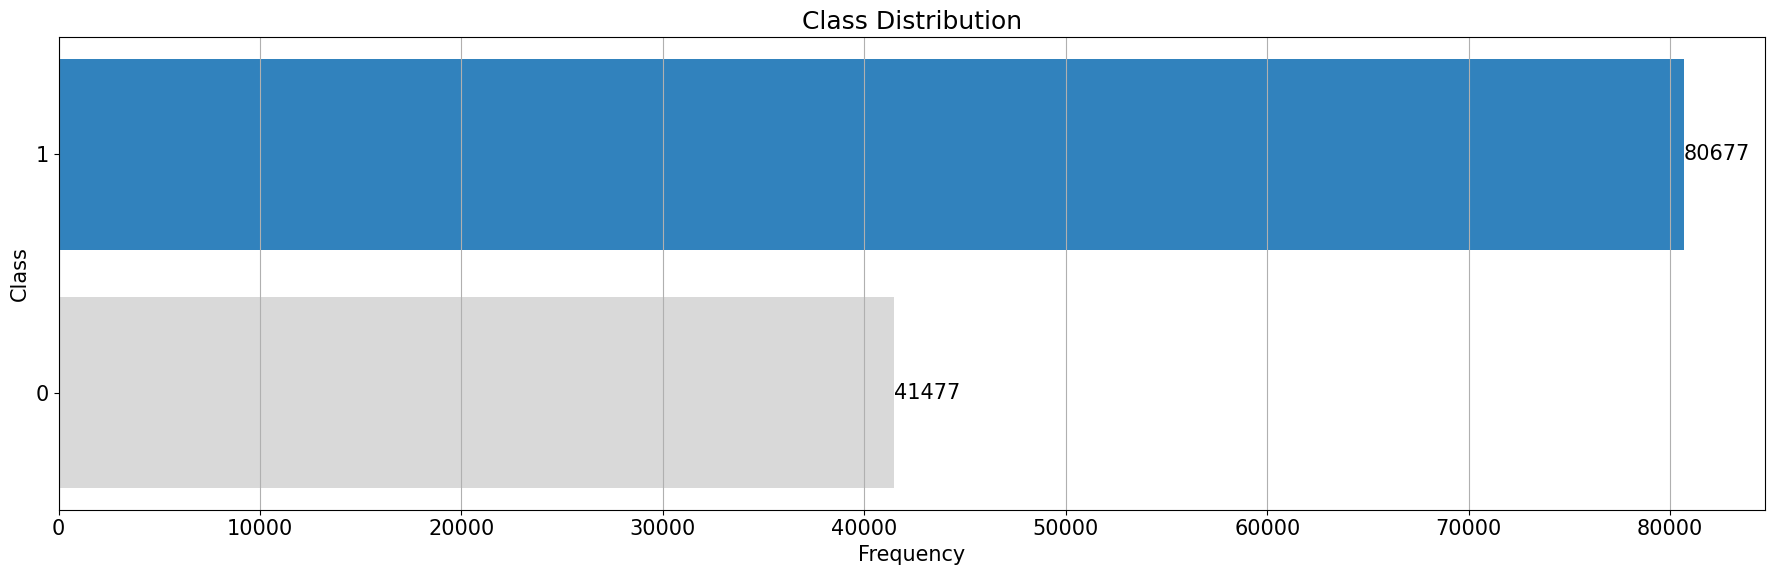

In [5]:
def barplot_column(df, column, top_n=None):
    class_counts = df[column].value_counts()

    if top_n:
        class_counts = class_counts[:top_n]
        
    colormap = cm.get_cmap('tab20c', len(class_counts))  
    colors = [colormap(i) for i in range(len(class_counts))]

    plt.figure(figsize=(18, max(6, 0.25 * len(class_counts)))) 
    plt.barh(class_counts.index.astype(str), class_counts.values, color=colors)  
    plt.title(f'{column} Distribution')
    plt.xlabel('Frequency')
    plt.ylabel(column)
    plt.gca().invert_yaxis()

    for i, value in enumerate(class_counts.values):
        plt.text(value, i, str(value), va='center') 

    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

barplot_column(df_all, 'Instance', top_n=10)
barplot_column(df_all, 'Class')

# **Exploratory Data Analysis**

## **Slugging Features**

In [8]:
def top_ids(df, n):
    id_counts = df['id'].value_counts()
    top_n_ids = id_counts.head(n).index 
    return top_n_ids

In [7]:
df_slugging = df_all[df_all['class']== 1].copy()
print('Real Slugging id:\n', df_slugging['id'].unique())

Real Slugging id:
 [  2   6   7   8   9  15  16  17  25  30  34  36  37  41  47  51  55  67
  83  88  89  93 101 103 105 109 110 112 118 126 134 142 145 150 158 160
 162 163 164 169 178 179 184 186 188 198 203 210 214 215 216 223 226 229
 233 244 247 252 258 263 264 267 274 275 278 284 289 292 296 297 298 301
 306 307 315 319 323 331 334 337 340 348 352 353 356 361 363 367 368 372
 377 389 393 396 399 409 411 413 417 429 431 432 436 437 443 448]


In [10]:
def amplitude_summary(df, ids, features):
    # Initialize list to store data
    data = []
    # Group by 'id'
    df_grouped = df.groupby('id')
    for id in ids:
        if id in df_grouped.groups:
            df_filtered = df_grouped.get_group(id)
            # Initialize a dictionary for this id
            summary = {'id': id}
            # Compute amplitude for each feature
            for feature in features:
                if feature in df_filtered.columns:
                    amplitude = df_filtered[feature].max() - df_filtered[feature].min()
                    summary[f'{feature}_amplitude'] = amplitude
            # Get additional info, e.g., 'Instance'
            summary['Instance'] = df_filtered['Instance'].iloc[0]
            data.append(summary)
    # Create dataframe from data
    df_amplitude = pd.DataFrame(data)
    return df_amplitude

def split_dataset_by_low_amplitude(df, is_low_columns):
    df_low_all = df[df[is_low_columns].all(axis=1)]
    df_rest = df[~df[is_low_columns].all(axis=1)]
    return df_low_all, df_rest

features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
ids = top_ids(df_slugging, 500)  
df_amplitude = amplitude_summary(df_slugging, ids, features)

In [14]:
def FFT(df_instance, column):
    start_t = df_instance.index.min()
    end_t = df_instance.index.max()
    time_series = df_instance[f'{column}']

    fft_data = np.fft.fft(time_series, n=len(time_series))

    frequencies = np.fft.fftfreq(len(time_series), (end_t - start_t).total_seconds() / 60)
    return frequencies, fft_data

def smooth_fft(frequencies, fft_data, window_size=20):

    real = np.real(fft_data)
    imaginary = np.imag(fft_data)
    phase = np.angle(fft_data)
    magnitude= np.abs(fft_data)
    df_fft = pd.DataFrame({'frequency': frequencies, 'real': real, 'imaginary': imaginary, 'magnitude': magnitude, 'phase': phase})
    
    # Apply a rolling mean to smooth the imaginary part
    df_fft['real'] = df_fft['real'].rolling(window=window_size, center=True).mean()
    df_fft['imaginary'] = df_fft['imaginary'].rolling(window=window_size, center=True).mean()
    df_fft['magnitude'] = df_fft['magnitude'].rolling(window=window_size, center=True).mean()
    df_fft['phase'] = df_fft['phase'].rolling(window=window_size, center=True).mean()

    df_fft['window_size'] = window_size

    df_fft.dropna(inplace=True)
    
    return df_fft

def fft_all_instances(df, columns, ids=None, window_size=20):
    fft_results = []  
    
    # Ensure the index is a datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)

    # If ids_to_process is provided, filter the DataFrame
    if ids is not None:
        df = df[df['id'].isin(ids)]

    # Group the DataFrame by 'id'
    grouped = df.groupby('id')

    for id_value, group in grouped:
        # Initialize a dictionary to hold FFT data for all features for this id
        fft_data_dict = {'id': id_value}
        if 'Instance' in group.columns:
            fft_data_dict['Instance'] = group['Instance'].iloc[0]
            fft_data_dict['is_well'] = group['is_well'].iloc[0]
            fft_data_dict['is_simulated'] = group['is_simulated'].iloc[0]
            fft_data_dict['Set'] = group['Set'].iloc[0]
            fft_data_dict['Class'] = group['Class'].iloc[0]

        # Loop over each feature
        for feature in columns:
            if feature in group.columns:
                # Apply the FFT function
                frequencies, fft_data = FFT(group, feature)
                # Apply smoothing to the FFT data
                df_fft = smooth_fft(frequencies, fft_data, window_size=window_size)

                # Rename columns to include feature name
                df_fft.rename(columns={
                    'frequency': f'{feature}_frequency',
                    'real': f'{feature}_real',
                    'imaginary': f'{feature}_imaginary',
                    'magnitude': f'{feature}_magnitude',
                    'phase': f'{feature}_phase'
                }, inplace=True)

                # Convert df_fft to dictionary and update fft_data_dict
                for col in df_fft.columns:
                    fft_data_dict[col] = df_fft[col].values

        # Convert fft_data_dict to DataFrame
        df_fft_id = pd.DataFrame(fft_data_dict)
        fft_results.append(df_fft_id)
    df_fft_all = pd.concat(fft_results, ignore_index=True)
    return df_fft_all

features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
amplitude_ids = df_amplitude['id'].tolist()
df_fft_amplitude = fft_all_instances(df_slugging, features, amplitude_ids, window_size=10)

display(df_fft_amplitude.head(2))


,id,Instance,is_well,is_simulated,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase
0,2,WELL-00014_20170925010031,1,0,Train,1,0.000055,4.520601e+08,3.503969e+07,5.025736e+08,0.834997,10,0.000055,1541.544507,-132.598559,1802.755781,-0.816297,0.000055,5.881635e+07,-1.002266e+07,9.182445e+07,0.259015,0.000055,1020.862721,-52.350694,1196.688180,0.125696
1,2,WELL-00014_20170925010031,1,0,Train,1,0.000066,5.319997e+06,3.541335e+07,5.769300e+07,1.109494,10,0.000066,-4.601281,-149.395890,281.324360,-1.011067,0.000066,6.470432e+06,-1.132210e+07,4.029988e+07,0.146281,0.000066,24.253091,-51.013276,200.836606,0.228827


In [15]:
def calculate_power_law(df, features):
    results = []
    
    # Group by 'id' and 'Instance' to consider each unique time series
    for (id, instance), group in df.groupby(['id', 'Instance']):
        for feature in features:
            freq_col = f'{feature}_frequency'
            mag_col = f'{feature}_magnitude'
            
            if freq_col in group.columns and mag_col in group.columns:
                frequencies = group[freq_col].values
                magnitudes = group[mag_col].values
                
                # Filter valid frequencies and magnitudes (non-zero, positive values)
                valid = (frequencies > 0) & (magnitudes > 0)
                if valid.any():
                    frequencies = frequencies[valid]
                    magnitudes = magnitudes[valid]
                    
                    log_freq = np.log10(frequencies)
                    log_mag = np.log10(magnitudes)
                    
                    # Perform linear regression in the log-log space
                    slope, intercept, r_value, p_value, std_err = linregress(log_freq, log_mag)
                    alpha = -slope
                    
                    result_dict = {
                        'id': id,
                        'Instance': instance,
                        'feature': feature,
                        'alpha': alpha,
                        'intercept': intercept,
                        'r_squared': r_value**2,
                        'p_value': p_value,
                        'std_err': std_err
                    }
                    results.append(result_dict)
    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(results)

features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
df_powerlaw_amplitude = calculate_power_law(df_fft_amplitude, features)

display(df_powerlaw_amplitude.head())

,id,Instance,feature,alpha,intercept,r_squared,p_value,std_err
0,2,WELL-00014_20170925010031,P-TPT,1.135950,2.873530,0.910672,2.055862e-77,0.029648
1,2,WELL-00014_20170925010031,T-TPT,1.154008,-2.441939,0.947242,6.888522e-94,0.022695
2,2,WELL-00014_20170925010031,P-MON-CKP,1.146151,3.062317,0.938605,3.810989e-89,0.024428
3,2,WELL-00014_20170925010031,T-JUS-CKP,1.352265,-3.212530,0.962848,7.389441e-105,0.022136
4,6,SIMULATED_00055,P-TPT,1.556252,0.272612,0.808006,6.794526e-185,0.033592


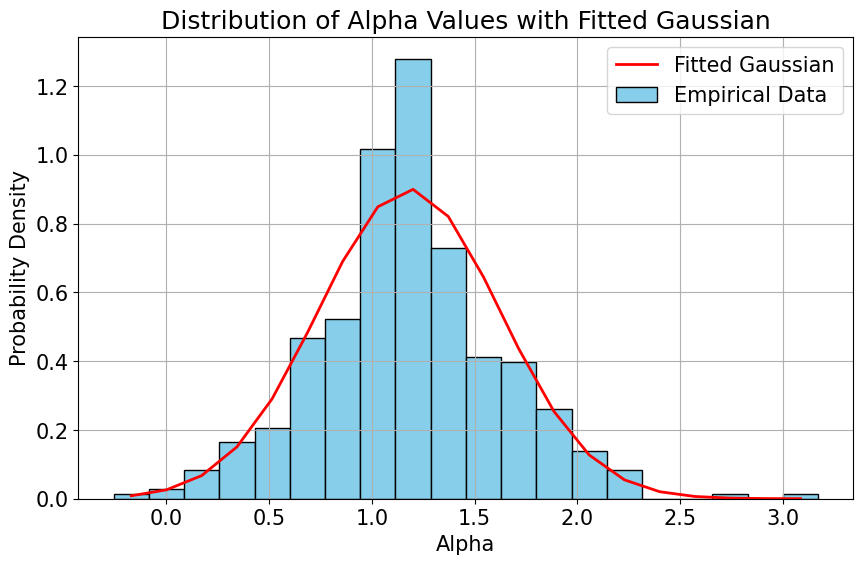

KL Divergence: 0.04918888311669894


In [16]:
# Assuming df_concatenated_all_slugging is already loaded and contains the 'alpha' column
data = df_powerlaw_amplitude['alpha'].dropna()

# Fit a Gaussian to the data
mu, std = norm.fit(data)

# Generate a Gaussian based on the fit
theoretical_dist = norm(mu, std)

# Create histogram of the data
data_hist, bin_edges = np.histogram(data, bins=20, density=True)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Calculate the PDF of the theoretical distribution over the bin centers
theoretical_pdf = theoretical_dist.pdf(bin_centers)

# Normalize the histogram to make it a valid probability distribution
data_hist /= data_hist.sum()

# Compute KL Divergence
kl_div = entropy(data_hist, theoretical_pdf)

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(data, bins=20, color='skyblue', edgecolor='black', density=True, label='Empirical Data')
plt.plot(bin_centers, theoretical_pdf, label='Fitted Gaussian', linewidth=2, color='red')
plt.title('Distribution of Alpha Values with Fitted Gaussian')
plt.xlabel('Alpha')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()

print('KL Divergence:', kl_div)

## **Flow Instability Features**

In [17]:
df_inst = df_all[df_all['class']== 0].copy()

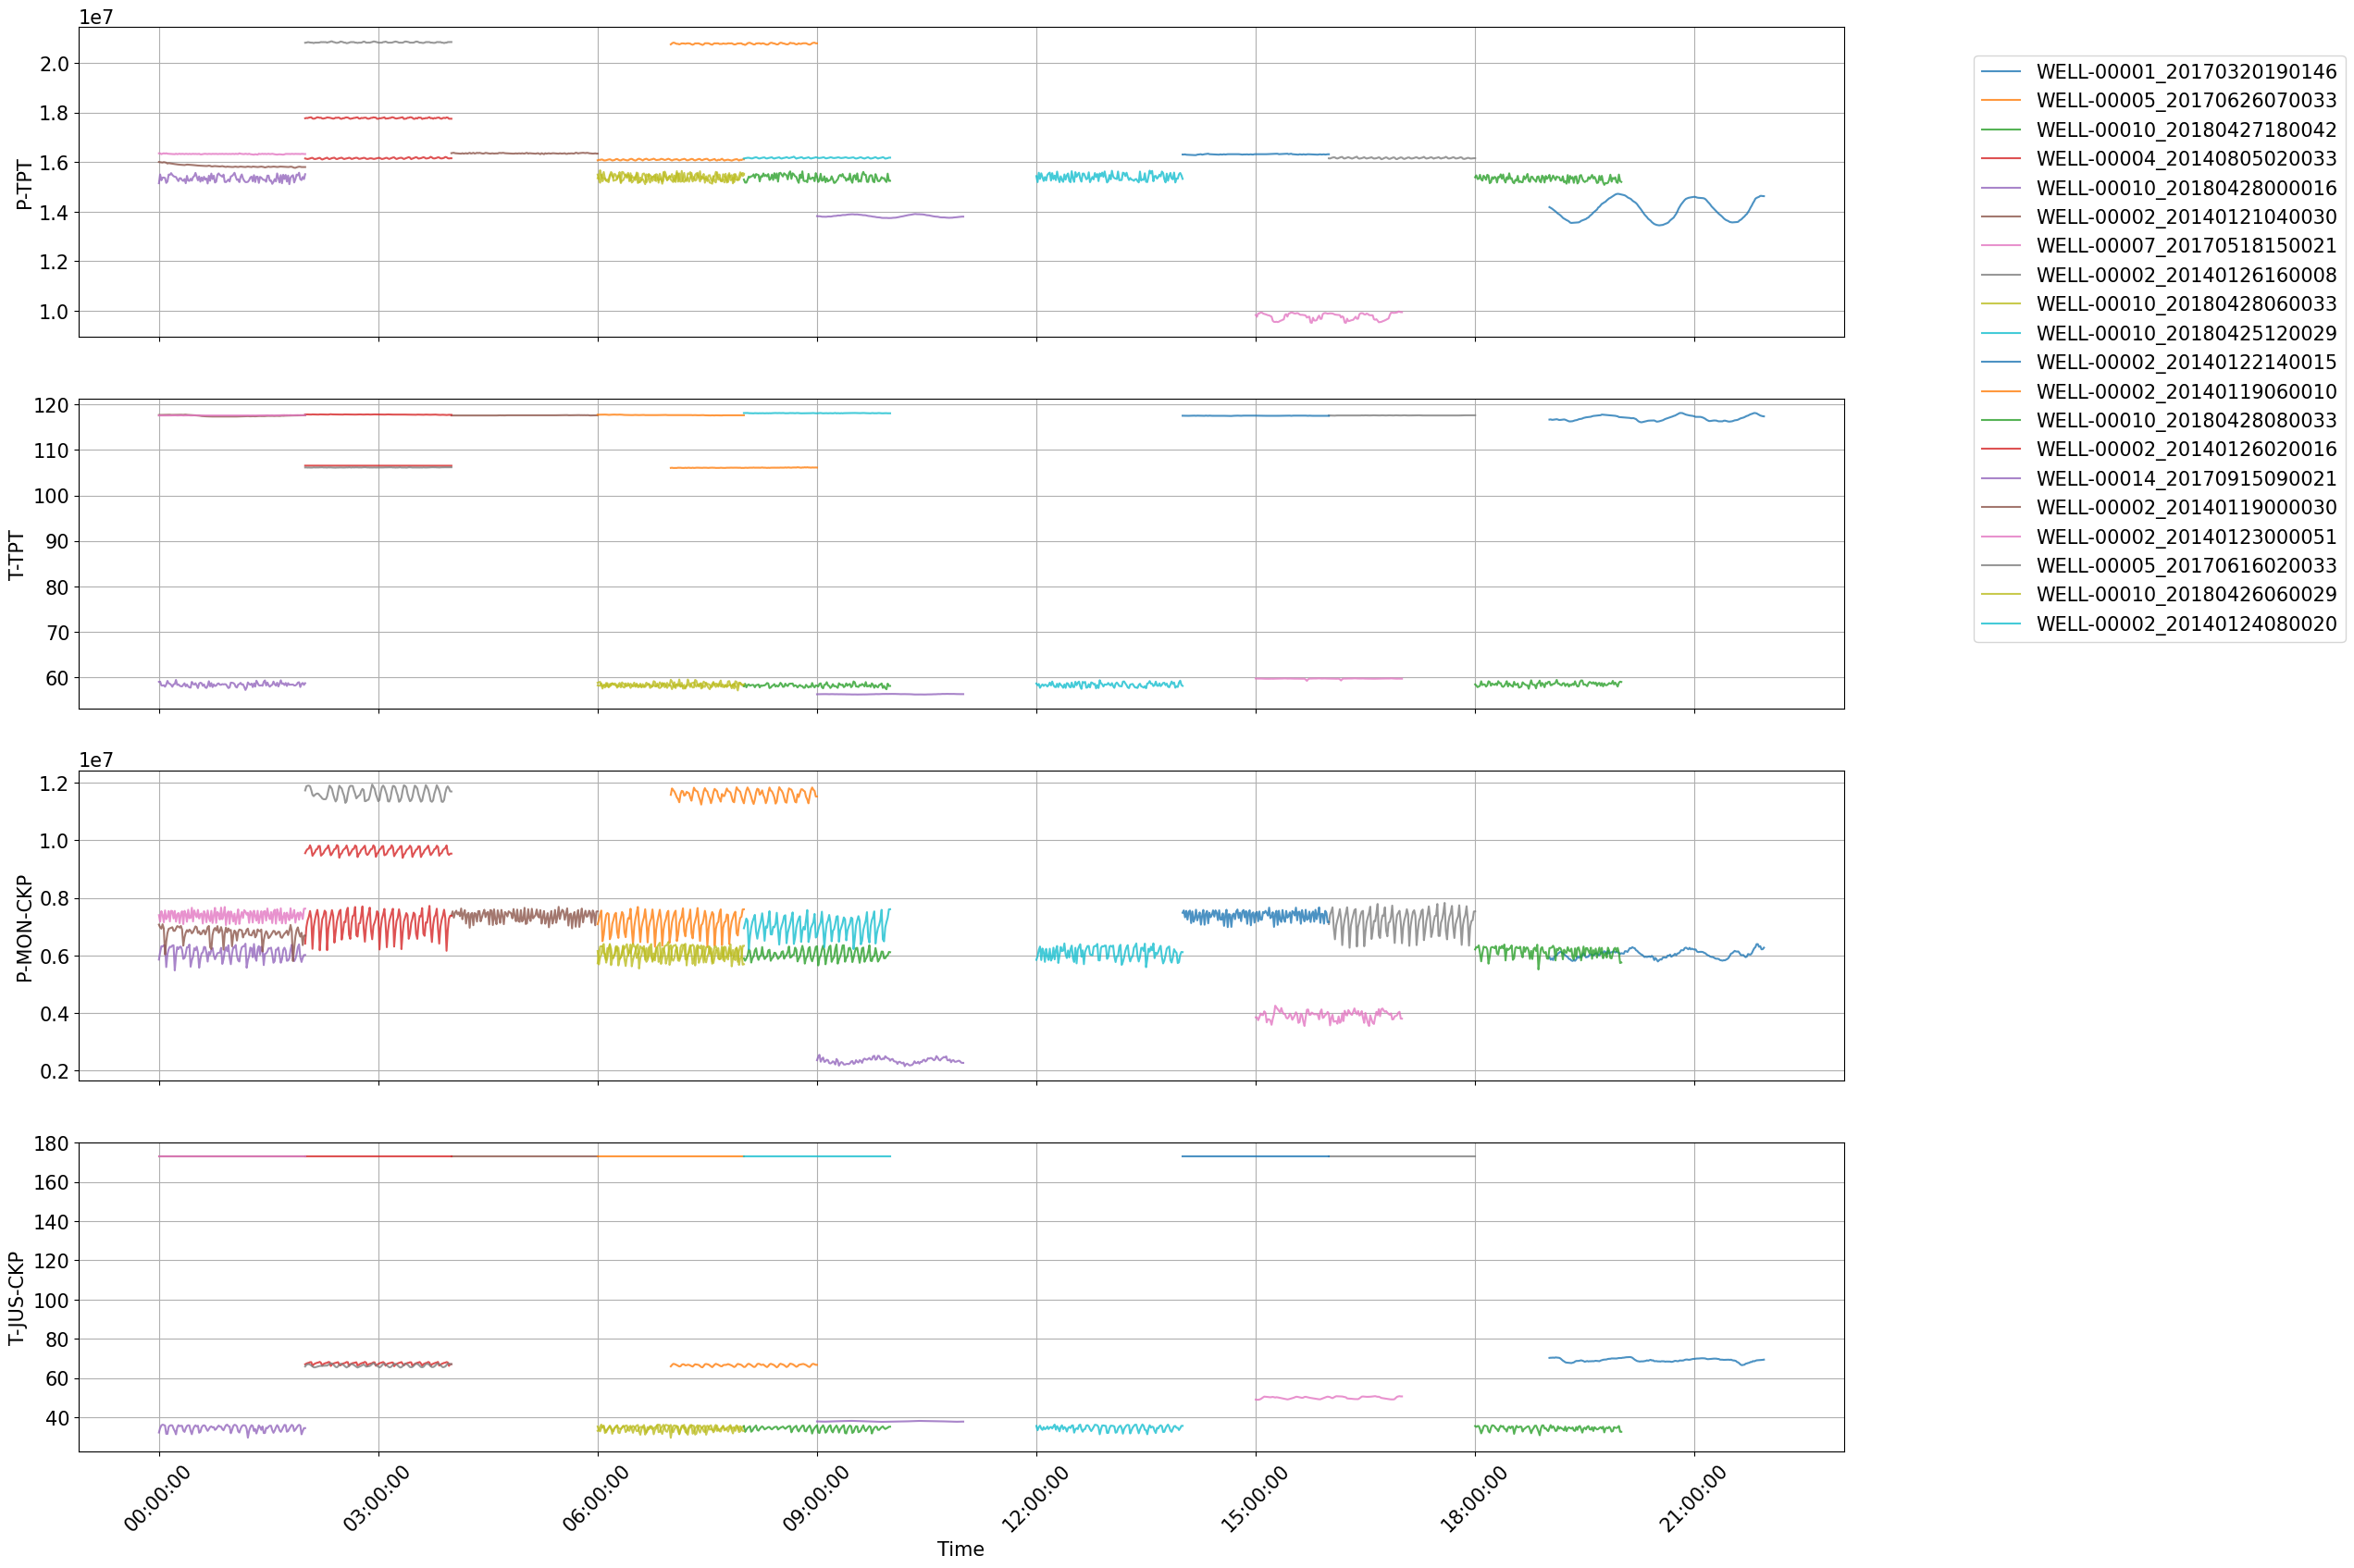

In [20]:
def plot_time_series(df, columns, ids, resample_interval='5H'):
    num_features = len(columns)
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(24, 5 * num_features), sharex=True)
    

    lines_labels = {}
    
    df_grouped = df.groupby('id')
    for id in ids:
        if id in df_grouped.groups:
            df_filtered = df_grouped.get_group(id).copy()
            
            instance_name = df_filtered['Instance'].iloc[0]
            df_filtered.index = pd.to_datetime(df_filtered.index.strftime('2017-01-01 %H:%M:%S'))
            df_filtered = df_filtered.resample(resample_interval).mean(numeric_only=True)
            
            for i, column in enumerate(columns):
                if column in df_filtered.columns:
                    line, = axes[i].plot(df_filtered.index, df_filtered[column], label=f'{instance_name}', alpha=0.8)
                    axes[i].set_ylabel(column)
                    axes[i].grid(True)
                    
                    label = line.get_label()
                    if label not in lines_labels:
                        lines_labels[label] = line
                        
    labels = list(lines_labels.keys())
    handles = list(lines_labels.values())
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.87), bbox_transform=plt.gcf().transFigure)
    
    plt.subplots_adjust(right=0.92)
    
    axes[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    
    plt.xticks(rotation=45)
    plt.xlabel('Time')
    plt.show()

features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
ids = top_ids(df_inst, 20)  
plot_time_series(df_inst, features, ids, resample_interval='1T')

In [21]:
features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
df_inst_ids = df_inst['id'].tolist()
df_fft_inst = fft_all_instances(df_inst, features, df_inst_ids, window_size=10)
df_fft_inst.head()

,id,Instance,is_well,is_simulated,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase
0,0,WELL-00005_20170626070033,1,0,Train,0,0.000344,2.515085e+08,16885.974628,2.515410e+08,-0.012250,10,0.000344,1283.565565,0.478515,1284.224952,1.597060,0.000344,1.407163e+08,152874.109842,1.409057e+08,0.226200,0.000344,806.877718,-0.161095,807.658166,-0.168190
1,0,WELL-00005_20170626070033,1,0,Train,0,0.000413,1.247295e+05,17748.839742,1.572268e+05,-0.008456,10,0.000413,-0.072061,0.484567,0.602493,1.835284,0.000413,5.889680e+05,229499.036831,7.955706e+05,0.270349,0.000413,2.141444,0.089044,2.976421,-0.125261
2,0,WELL-00005_20170626070033,1,0,Train,0,0.000482,1.292334e+05,7420.275558,1.547909e+05,-0.060453,10,0.000482,-0.124881,0.345041,0.453304,1.834928,0.000482,5.952269e+05,359930.608730,8.775583e+05,0.383280,0.000482,2.219157,0.321812,3.179718,-0.091234
3,0,WELL-00005_20170626070033,1,0,Train,0,0.000551,1.348060e+05,-1651.588768,1.595879e+05,-0.134605,10,0.000551,-0.139270,0.233189,0.373158,1.409338,0.000551,5.701417e+05,450043.616880,9.276497e+05,0.477339,0.000551,2.223521,0.302825,3.172452,-0.098038
4,0,WELL-00005_20170626070033,1,0,Train,0,0.000620,1.463926e+05,21369.620043,1.718063e+05,-0.055384,10,0.000620,-0.072104,0.164959,0.304041,1.254458,0.000620,7.240242e+05,775657.321919,1.240938e+06,0.648266,0.000620,2.872350,0.857567,3.988470,-0.053186


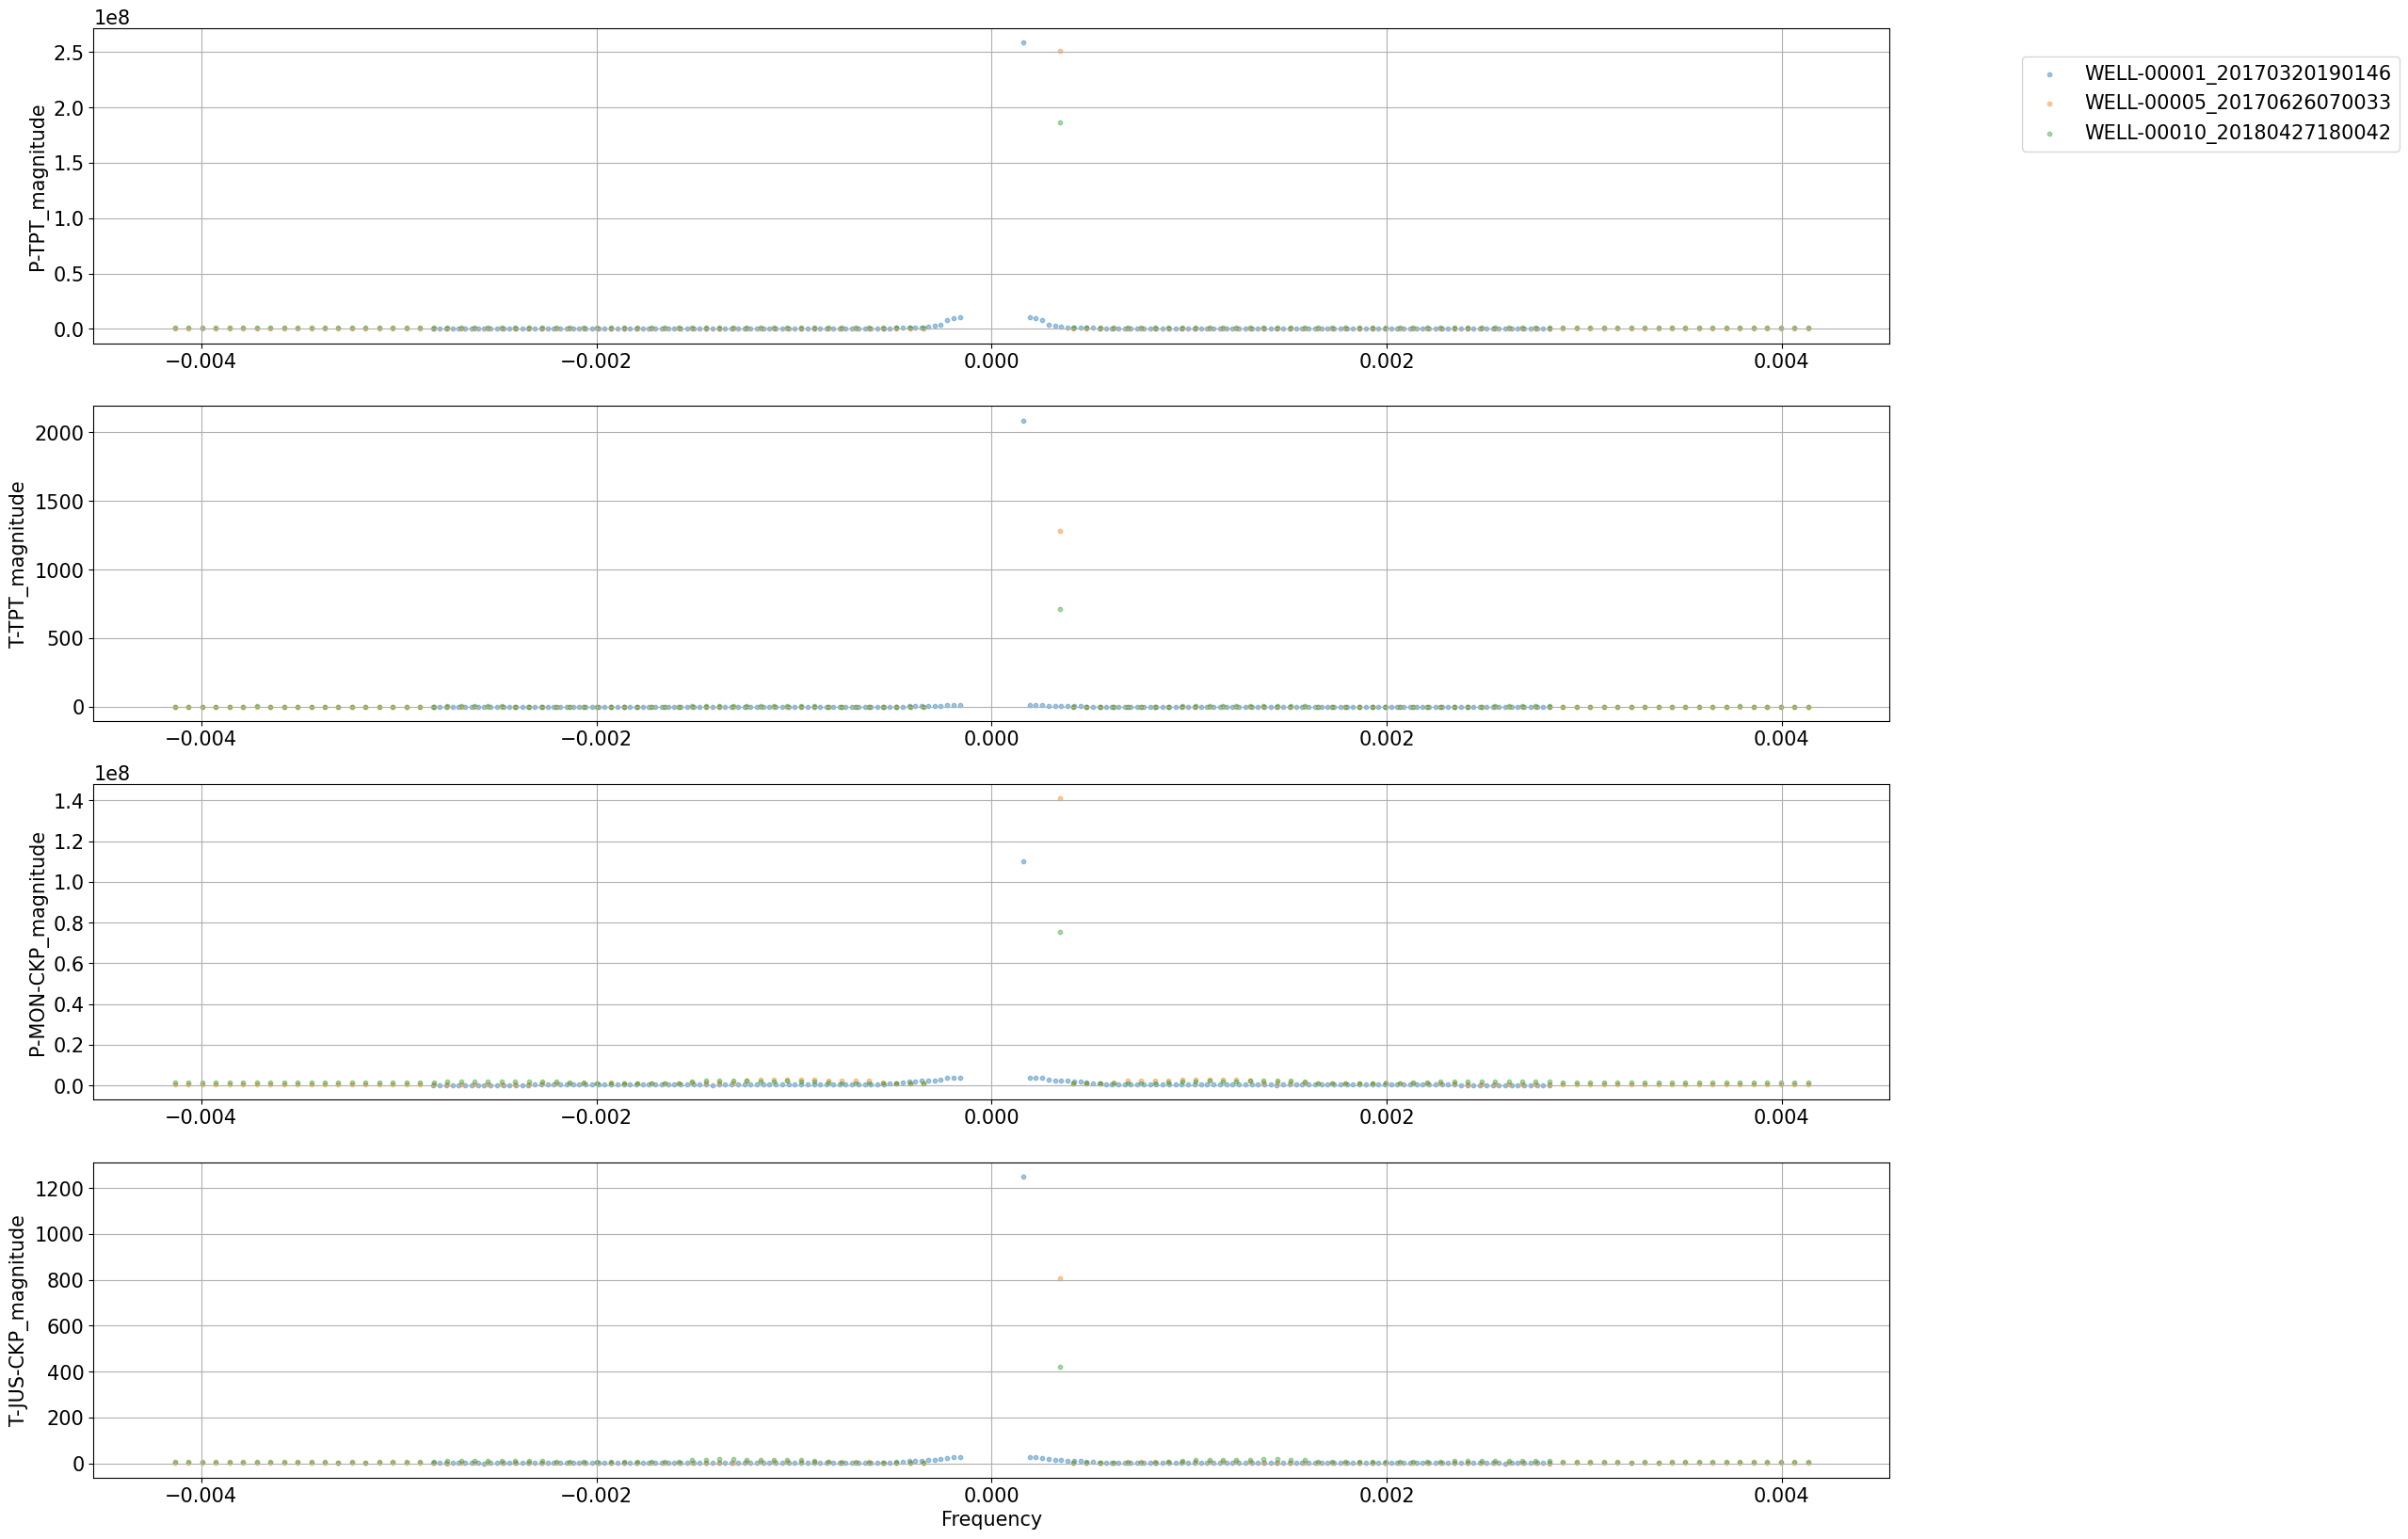

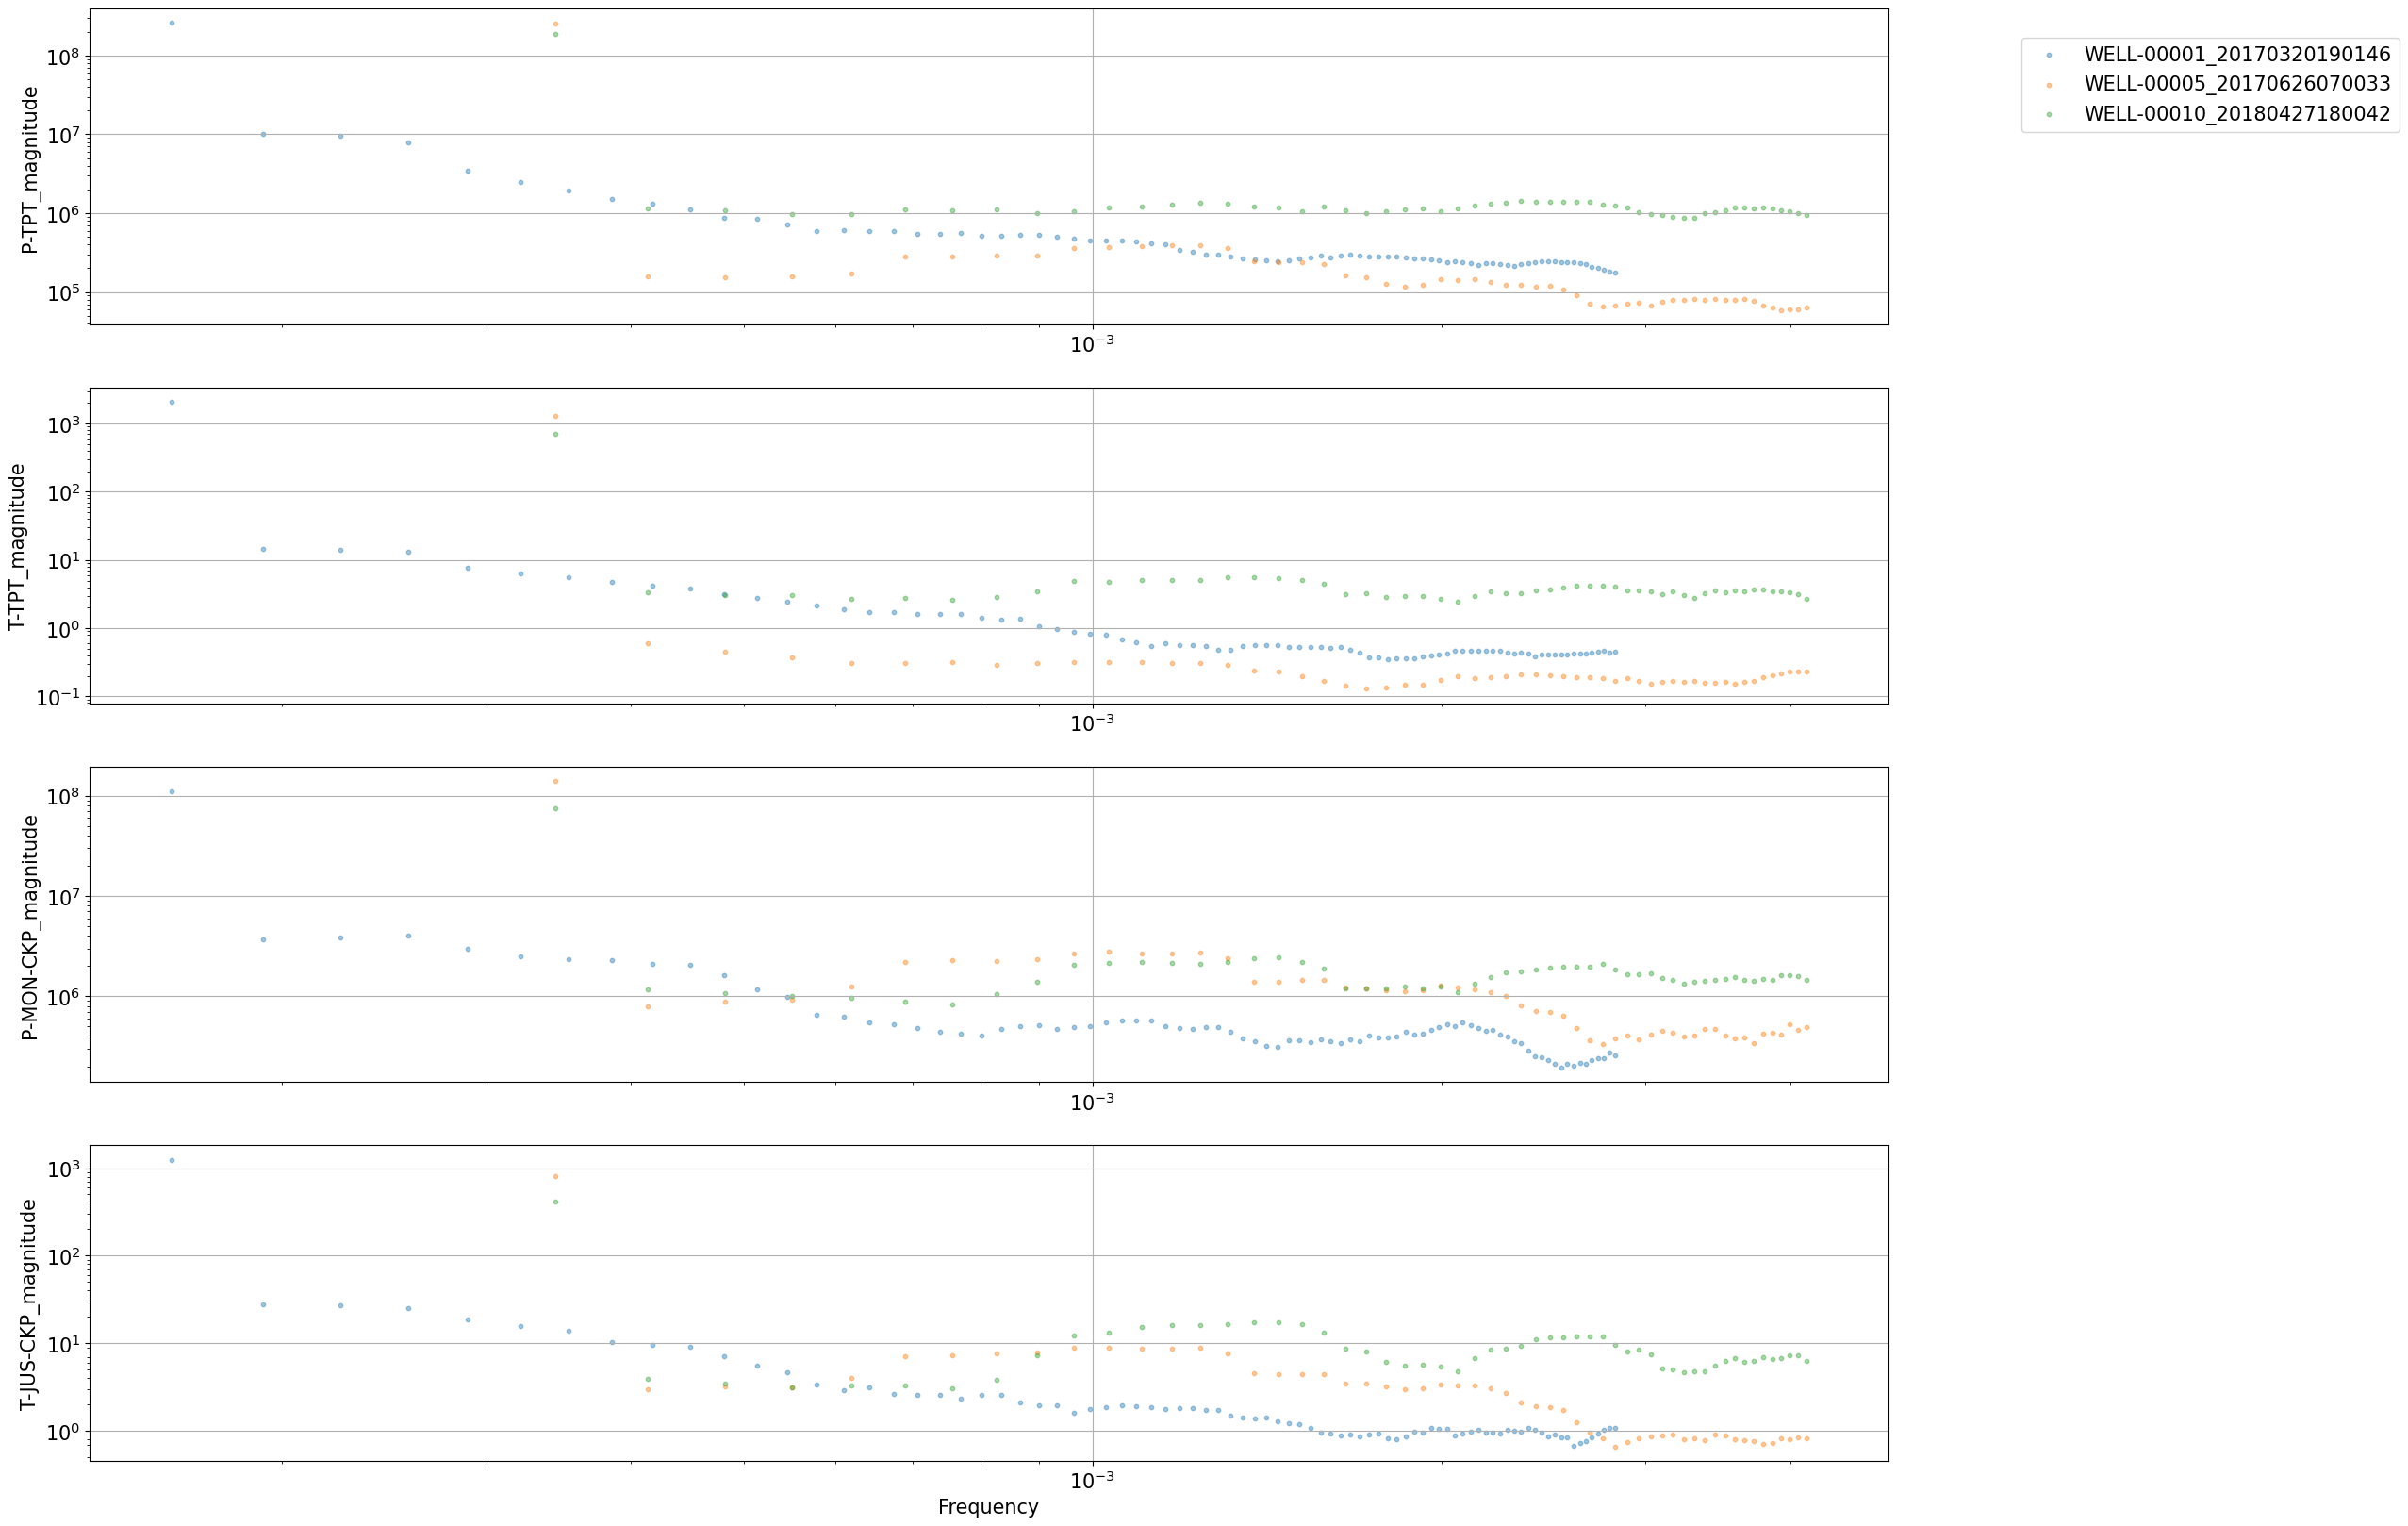

In [24]:
def plot_fft_components(df, columns, ids,  log_log=True):
    num_features = len(columns)
    fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(24, 5 * num_features), sharex=False)
    
    if num_features == 1:
        axes = [axes]  # Ensure axes is iterable

    lines_labels = {}
    
    df_grouped = df.groupby('id')
    for id_value in ids:
        if id_value in df_grouped.groups:
            df_filtered = df_grouped.get_group(id_value).copy()
            instance_name = df_filtered['Instance'].iloc[0]
            
            for i, column in enumerate(columns):
                # Determine the corresponding frequency column
                suffixes = ['_magnitude', '_real', '_imaginary', '_phase']
                freq_col = None
                for suffix in suffixes:
                    if column.endswith(suffix):
                        freq_col = column.replace(suffix, '_frequency')
                        break
                if freq_col is None:
                    freq_col = 'frequency'  # Default frequency column if no suffix matches
                
                if freq_col in df_filtered.columns and column in df_filtered.columns:
                    frequencies = df_filtered[freq_col].values
                    values = df_filtered[column].values
                    
                    # Use scatter plot instead of line plot
                    scatter = axes[i].scatter(frequencies, values, label=f'{instance_name}', alpha=0.4, s = 10)
                    axes[i].set_ylabel(column)
                    axes[i].grid(True)
                    
                    # Set y-axis to log scale for all components except for phase
                    if not column.endswith('_phase'):
                        if log_log:
                            axes[i].set_yscale('log')
                            axes[i].set_xscale('log')
                    
                    label = scatter.get_label()
                    if label not in lines_labels:
                        lines_labels[label] = scatter
                        
    # Create a legend outside the plots
    labels = list(lines_labels.keys())
    handles = list(lines_labels.values())
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 0.87), bbox_transform=plt.gcf().transFigure)
    
    plt.subplots_adjust(right=0.92)
    plt.xlabel('Frequency')
    plt.show()

features = ['P-TPT_magnitude', 'T-TPT_magnitude', 'P-MON-CKP_magnitude', 'T-JUS-CKP_magnitude']
df_inst_ids = df_inst['id'].tolist()
df_inst_ids = top_ids(df_inst, 3) 

plot_fft_components(df_fft_inst, features, df_inst_ids, log_log=False)
plot_fft_components(df_fft_inst, features, df_inst_ids)

In [27]:
features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']

df_powerlaw_inst_amplitude = calculate_power_law(df_fft_inst, features)


# Display the new DataFrame with power law values
display(df_powerlaw_inst_amplitude.head())

,id,Instance,feature,alpha,intercept,r_squared,p_value,std_err
0,0,WELL-00005_20170626070033,P-TPT,1.233080,1.810095,0.464996,7.196677e-09,0.179990
1,0,WELL-00005_20170626070033,T-TPT,0.992308,-3.309232,0.284601,2.299780e-05,0.214095
2,0,WELL-00005_20170626070033,P-MON-CKP,1.122676,2.904552,0.563027,2.785625e-11,0.134592
3,0,WELL-00005_20170626070033,T-JUS-CKP,1.484596,-3.669363,0.651819,5.640971e-14,0.147656
4,1,WELL-00002_20131215000010,P-TPT,1.331940,0.854357,0.432964,3.575659e-08,0.207428


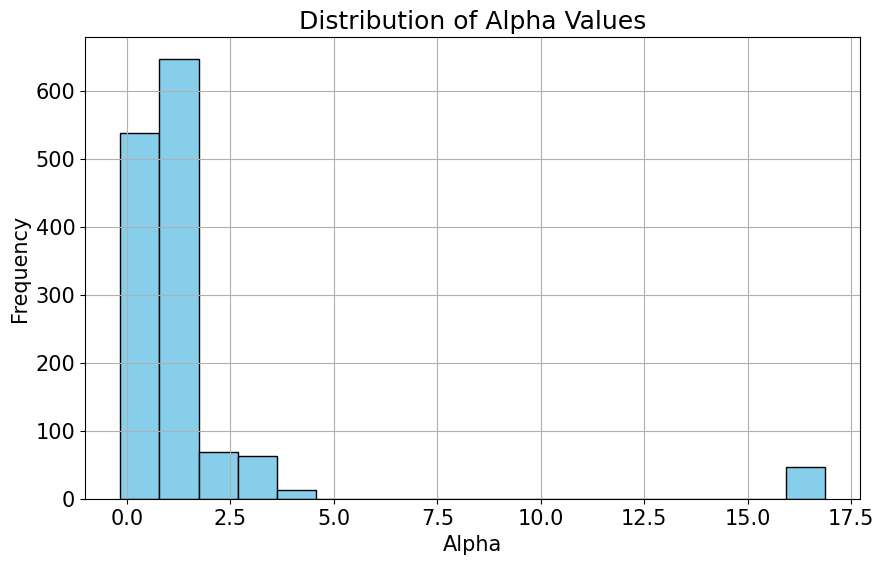

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(df_powerlaw_inst_amplitude['alpha'], bins=18, color='skyblue', edgecolor='black')
plt.title('Distribution of Alpha Values')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [30]:
def merge_data(df1, df2):
    df1_pivot = df1.pivot(index=['id', 'Instance'], columns='feature')
    df1_pivot.columns = ['{}_{}'.format(feature, stat) for stat, feature in df1_pivot.columns]
    df1_pivot.reset_index(inplace=True)
    df_merged = df2.merge(df1_pivot, on=['id', 'Instance'], how='left')
    return df_merged

df_fft_inst_amplitude = merge_data(df_powerlaw_inst_amplitude, df_fft_inst)

display(df_fft_inst_amplitude.head())

,id,Instance,is_well,is_simulated,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared,P-MON-CKP_p_value,P-TPT_p_value,T-JUS-CKP_p_value,T-TPT_p_value,P-MON-CKP_std_err,P-TPT_std_err,T-JUS-CKP_std_err,T-TPT_std_err
0,0,WELL-00005_20170626070033,1,0,Train,0,0.000344,2.515085e+08,16885.974628,2.515410e+08,-0.012250,10,0.000344,1283.565565,0.478515,1284.224952,1.597060,0.000344,1.407163e+08,152874.109842,1.409057e+08,0.226200,0.000344,806.877718,-0.161095,807.658166,-0.168190,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
1,0,WELL-00005_20170626070033,1,0,Train,0,0.000413,1.247295e+05,17748.839742,1.572268e+05,-0.008456,10,0.000413,-0.072061,0.484567,0.602493,1.835284,0.000413,5.889680e+05,229499.036831,7.955706e+05,0.270349,0.000413,2.141444,0.089044,2.976421,-0.125261,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
2,0,WELL-00005_20170626070033,1,0,Train,0,0.000482,1.292334e+05,7420.275558,1.547909e+05,-0.060453,10,0.000482,-0.124881,0.345041,0.453304,1.834928,0.000482,5.952269e+05,359930.608730,8.775583e+05,0.383280,0.000482,2.219157,0.321812,3.179718,-0.091234,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
3,0,WELL-00005_20170626070033,1,0,Train,0,0.000551,1.348060e+05,-1651.588768,1.595879e+05,-0.134605,10,0.000551,-0.139270,0.233189,0.373158,1.409338,0.000551,5.701417e+05,450043.616880,9.276497e+05,0.477339,0.000551,2.223521,0.302825,3.172452,-0.098038,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
4,0,WELL-00005_20170626070033,1,0,Train,0,0.000620,1.463926e+05,21369.620043,1.718063e+05,-0.055384,10,0.000620,-0.072104,0.164959,0.304041,1.254458,0.000620,7.240242e+05,775657.321919,1.240938e+06,0.648266,0.000620,2.872350,0.857567,3.988470,-0.053186,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095


# **Data Splitting**

In [31]:
df_all_ids = df_all['id'].tolist()
df_fft_all = fft_all_instances(df_all, features, df_all_ids, window_size=10)
display(df_fft_all.head())

,id,Instance,is_well,is_simulated,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase
0,0,WELL-00005_20170626070033,1,0,Train,0,0.000344,2.515085e+08,16885.974628,2.515410e+08,-0.012250,10,0.000344,1283.565565,0.478515,1284.224952,1.597060,0.000344,1.407163e+08,152874.109842,1.409057e+08,0.226200,0.000344,806.877718,-0.161095,807.658166,-0.168190
1,0,WELL-00005_20170626070033,1,0,Train,0,0.000413,1.247295e+05,17748.839742,1.572268e+05,-0.008456,10,0.000413,-0.072061,0.484567,0.602493,1.835284,0.000413,5.889680e+05,229499.036831,7.955706e+05,0.270349,0.000413,2.141444,0.089044,2.976421,-0.125261
2,0,WELL-00005_20170626070033,1,0,Train,0,0.000482,1.292334e+05,7420.275558,1.547909e+05,-0.060453,10,0.000482,-0.124881,0.345041,0.453304,1.834928,0.000482,5.952269e+05,359930.608730,8.775583e+05,0.383280,0.000482,2.219157,0.321812,3.179718,-0.091234
3,0,WELL-00005_20170626070033,1,0,Train,0,0.000551,1.348060e+05,-1651.588768,1.595879e+05,-0.134605,10,0.000551,-0.139270,0.233189,0.373158,1.409338,0.000551,5.701417e+05,450043.616880,9.276497e+05,0.477339,0.000551,2.223521,0.302825,3.172452,-0.098038
4,0,WELL-00005_20170626070033,1,0,Train,0,0.000620,1.463926e+05,21369.620043,1.718063e+05,-0.055384,10,0.000620,-0.072104,0.164959,0.304041,1.254458,0.000620,7.240242e+05,775657.321919,1.240938e+06,0.648266,0.000620,2.872350,0.857567,3.988470,-0.053186


In [32]:
features = ['P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP']
df_powerlaw = calculate_power_law(df_fft_all, features)

# Display the new DataFrame with power law values
display(df_powerlaw.head())

,id,Instance,feature,alpha,intercept,r_squared,p_value,std_err
0,0,WELL-00005_20170626070033,P-TPT,1.233080,1.810095,0.464996,7.196677e-09,0.179990
1,0,WELL-00005_20170626070033,T-TPT,0.992308,-3.309232,0.284601,2.299780e-05,0.214095
2,0,WELL-00005_20170626070033,P-MON-CKP,1.122676,2.904552,0.563027,2.785625e-11,0.134592
3,0,WELL-00005_20170626070033,T-JUS-CKP,1.484596,-3.669363,0.651819,5.640971e-14,0.147656
4,1,WELL-00002_20131215000010,P-TPT,1.331940,0.854357,0.432964,3.575659e-08,0.207428


In [33]:
df_fft_merged = merge_data(df_powerlaw, df_fft_all)

display(df_fft_merged.head())

,id,Instance,is_well,is_simulated,Set,Class,P-TPT_frequency,P-TPT_real,P-TPT_imaginary,P-TPT_magnitude,P-TPT_phase,window_size,T-TPT_frequency,T-TPT_real,T-TPT_imaginary,T-TPT_magnitude,T-TPT_phase,P-MON-CKP_frequency,P-MON-CKP_real,P-MON-CKP_imaginary,P-MON-CKP_magnitude,P-MON-CKP_phase,T-JUS-CKP_frequency,T-JUS-CKP_real,T-JUS-CKP_imaginary,T-JUS-CKP_magnitude,T-JUS-CKP_phase,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared,P-MON-CKP_p_value,P-TPT_p_value,T-JUS-CKP_p_value,T-TPT_p_value,P-MON-CKP_std_err,P-TPT_std_err,T-JUS-CKP_std_err,T-TPT_std_err
0,0,WELL-00005_20170626070033,1,0,Train,0,0.000344,2.515085e+08,16885.974628,2.515410e+08,-0.012250,10,0.000344,1283.565565,0.478515,1284.224952,1.597060,0.000344,1.407163e+08,152874.109842,1.409057e+08,0.226200,0.000344,806.877718,-0.161095,807.658166,-0.168190,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
1,0,WELL-00005_20170626070033,1,0,Train,0,0.000413,1.247295e+05,17748.839742,1.572268e+05,-0.008456,10,0.000413,-0.072061,0.484567,0.602493,1.835284,0.000413,5.889680e+05,229499.036831,7.955706e+05,0.270349,0.000413,2.141444,0.089044,2.976421,-0.125261,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
2,0,WELL-00005_20170626070033,1,0,Train,0,0.000482,1.292334e+05,7420.275558,1.547909e+05,-0.060453,10,0.000482,-0.124881,0.345041,0.453304,1.834928,0.000482,5.952269e+05,359930.608730,8.775583e+05,0.383280,0.000482,2.219157,0.321812,3.179718,-0.091234,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
3,0,WELL-00005_20170626070033,1,0,Train,0,0.000551,1.348060e+05,-1651.588768,1.595879e+05,-0.134605,10,0.000551,-0.139270,0.233189,0.373158,1.409338,0.000551,5.701417e+05,450043.616880,9.276497e+05,0.477339,0.000551,2.223521,0.302825,3.172452,-0.098038,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095
4,0,WELL-00005_20170626070033,1,0,Train,0,0.000620,1.463926e+05,21369.620043,1.718063e+05,-0.055384,10,0.000620,-0.072104,0.164959,0.304041,1.254458,0.000620,7.240242e+05,775657.321919,1.240938e+06,0.648266,0.000620,2.872350,0.857567,3.988470,-0.053186,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601,2.785625e-11,7.196677e-09,5.640971e-14,0.000023,0.134592,0.17999,0.147656,0.214095


In [34]:
filter_data = ['id','is_well', 'is_simulated', 'Set', 'P-TPT_frequency', 
       'P-TPT_magnitude', 'T-TPT_frequency',
       'T-TPT_magnitude', 
       'P-MON-CKP_frequency',
       'P-MON-CKP_magnitude',  'T-JUS-CKP_frequency',
        'T-JUS-CKP_magnitude',
        'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
       'T-TPT_alpha', 'P-MON-CKP_intercept', 'P-TPT_intercept',
       'T-JUS-CKP_intercept', 'T-TPT_intercept', 'P-MON-CKP_r_squared',
       'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared', 'Class']

df_fft = df_fft_merged[filter_data]


In [35]:
df_fft_train = df_fft[df_fft['Set'] == 'Train'].copy()
df_fft_test = df_fft[df_fft['Set'] == 'Test'].copy()

df_fft_train.drop(columns=['Set'], inplace=True)
df_fft_test.drop(columns=['Set'], inplace=True)

Y_train = df_fft_train['Class'].values.astype(int)
Y_test = df_fft_test['Class'].values.astype(int)

X_train = df_fft_train.drop(columns=['Class'])
X_test = df_fft_test.drop(columns=['Class'])

display(X_train.head())
display(X_test.head())

,id,is_well,is_simulated,P-TPT_frequency,P-TPT_magnitude,T-TPT_frequency,T-TPT_magnitude,P-MON-CKP_frequency,P-MON-CKP_magnitude,T-JUS-CKP_frequency,T-JUS-CKP_magnitude,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared
0,0,1,0,0.000344,2.515410e+08,0.000344,1284.224952,0.000344,1.409057e+08,0.000344,807.658166,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601
1,0,1,0,0.000413,1.572268e+05,0.000413,0.602493,0.000413,7.955706e+05,0.000413,2.976421,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601
2,0,1,0,0.000482,1.547909e+05,0.000482,0.453304,0.000482,8.775583e+05,0.000482,3.179718,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601
3,0,1,0,0.000551,1.595879e+05,0.000551,0.373158,0.000551,9.276497e+05,0.000551,3.172452,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601
4,0,1,0,0.000620,1.718063e+05,0.000620,0.304041,0.000620,1.240938e+06,0.000620,3.988470,1.122676,1.23308,1.484596,0.992308,2.904552,1.810095,-3.669363,-3.309232,0.563027,0.464996,0.651819,0.284601


,id,is_well,is_simulated,P-TPT_frequency,P-TPT_magnitude,T-TPT_frequency,T-TPT_magnitude,P-MON-CKP_frequency,P-MON-CKP_magnitude,T-JUS-CKP_frequency,T-JUS-CKP_magnitude,P-MON-CKP_alpha,P-TPT_alpha,T-JUS-CKP_alpha,T-TPT_alpha,P-MON-CKP_intercept,P-TPT_intercept,T-JUS-CKP_intercept,T-TPT_intercept,P-MON-CKP_r_squared,P-TPT_r_squared,T-JUS-CKP_r_squared,T-TPT_r_squared
94027,360,1,0,0.00035,2.133347e+08,0.00035,1278.370342,0.00035,1.160394e+08,0.00035,819.088643,0.632378,0.712413,0.473986,1.704726,4.127959,3.21927,-0.660874,-6.53632,0.211959,0.190039,0.136076,0.426781
94028,360,1,0,0.00042,1.061163e+05,0.00042,0.069176,0.00042,4.639631e+05,0.00042,2.087080,0.632378,0.712413,0.473986,1.704726,4.127959,3.21927,-0.660874,-6.53632,0.211959,0.190039,0.136076,0.426781
94029,360,1,0,0.00049,9.377610e+04,0.00049,0.047697,0.00049,4.702285e+05,0.00049,2.455566,0.632378,0.712413,0.473986,1.704726,4.127959,3.21927,-0.660874,-6.53632,0.211959,0.190039,0.136076,0.426781
94030,360,1,0,0.00056,9.003237e+04,0.00056,0.037848,0.00056,4.788243e+05,0.00056,2.396435,0.632378,0.712413,0.473986,1.704726,4.127959,3.21927,-0.660874,-6.53632,0.211959,0.190039,0.136076,0.426781
94031,360,1,0,0.00063,9.009518e+04,0.00063,0.031769,0.00063,5.121462e+05,0.00063,2.761362,0.632378,0.712413,0.473986,1.704726,4.127959,3.21927,-0.660874,-6.53632,0.211959,0.190039,0.136076,0.426781


In [36]:
class ClassifierParameterizer(object):
    """
    Class built to utilize for model training with optuna.
    """
    CATBOOST = 'catboost'
    XGBOOST_NAME = 'xgboost'
    RF_NAME = 'random_forest'

    def __init__(self, model_name, model_parameters, seed: int = 42):
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.seed = seed

    def select_model(self, **kwargs):
        """
        Select the model based on model_name.
        """
        if self.model_name == self.XGBOOST_NAME:
            return XGBClassifier(random_state=self.seed,verbose=0, **kwargs)
        if self.model_name == self.CATBOOST:
            return CatBoostClassifier(random_state=self.seed,verbose=0, **kwargs)
        elif self.model_name == self.RF_NAME:
            return RandomForestClassifier(random_state=self.seed,verbose=0, **kwargs)
        else:
            raise ValueError(f"Unsupported model: {self.model_name}")

    def create_model_parameters(self, trial):
        """
        Create model-specific hyperparameters using an Optuna trial.
        This version handles float and int types with optional step parameters.
        """
        params = {}

        for param_name, param_info in self.model_parameters.items():

            if param_info['type'] == 'float':
                # Check if a step parameter exists
                if 'step' in param_info:
                    params[param_name] = trial.suggest_float(
                        name=param_name,
                        low=param_info['low'],
                        high=param_info['high'],
                        step=param_info['step'],  # Use step if present
                        log=param_info.get('log', False)
                    )
                else:
                    params[param_name] = trial.suggest_float(
                        name=param_name,
                        low=param_info['low'],
                        high=param_info['high'],
                        log=param_info.get('log', False)  # No step, continuous search
                    )

            elif param_info['type'] == 'int':
                params[param_name] = trial.suggest_int(
                    name=param_name,
                    low=param_info['low'],
                    high=param_info['high'],
                    step=param_info.get('step', 1)  # Use step if present, else use 1
                )

            elif param_info['type'] == 'categorical':
                params[param_name] = trial.suggest_categorical(
                    name=param_name,
                    choices=param_info['choices']
                )

        return params

In [37]:
def objective(trial, X_train, y_train, model_name, model_parameters, categorical_features, numerical_features):
    
    model_parameterizer = ClassifierParameterizer(model_name, model_parameters)
    params = model_parameterizer.create_model_parameters(trial)
    classifier = model_parameterizer.select_model(**params)
    
    
    ### Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numerical_features)
        ])
    
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor), 
        ('classifier', classifier) 
    ])
    ###

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'f1': make_scorer(f1_score, average='macro')
    }
    
    cv_results = cross_validate(
        pipeline, 
        X_train, 
        y_train, 
        cv=kf, 
        scoring=scoring,  
        return_train_score=True,  
        n_jobs=-1
    )
    
    mean_test_accuracy = np.mean(cv_results['test_accuracy'])
    mean_test_f1 = np.mean(cv_results['test_f1'])
    
    print(f"Mean Test Accuracy: {mean_test_accuracy}")
    print(f"Mean Test F1: {mean_test_f1}")
    
    return mean_test_f1

In [ ]:
model_parameters_catboost = {
    'learning_rate': {'type': 'float', 'low': 1e-5, 'high': 0.1, 'log': False},
    'depth': {'type': 'int', 'low': 3, 'high': 7},
    'iterations': {'type': 'int', 'low': 100, 'high': 1000},
    'l2_leaf_reg': {'type': 'float', 'low': 0.001, 'high': 1000, 'log': False},
    'random_strength': {'type': 'float', 'low': 0.001, 'high': 1000, 'log': False},
    'subsample': {'type': 'float', 'low': 0.1, 'high': 0.9}
}

categorical_features = ['id','is_well', 'is_simulated']
numerical_features =  [ 'P-TPT_frequency', 
       'P-TPT_magnitude', 'T-TPT_frequency',
       'T-TPT_magnitude', 
       'P-MON-CKP_frequency',
       'P-MON-CKP_magnitude',  'T-JUS-CKP_frequency',
        'T-JUS-CKP_magnitude',
        'P-MON-CKP_alpha', 'P-TPT_alpha', 'T-JUS-CKP_alpha',
       'T-TPT_alpha', 'P-MON-CKP_intercept', 'P-TPT_intercept',
       'T-JUS-CKP_intercept', 'T-TPT_intercept', 'P-MON-CKP_r_squared',
       'P-TPT_r_squared', 'T-JUS-CKP_r_squared', 'T-TPT_r_squared']



study = optuna.create_study(direction='maximize')  # Here we use 'maximize' because higher F1 is better
study.optimize(lambda trial: objective(trial, X_train, Y_train, 'catboost', model_parameters_catboost, categorical_features, numerical_features), n_trials=5)


In [ ]:
best_params = study.best_params
best_value = study.best_value
trial = study.best_trial

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_value}")

model_parameterizer = ClassifierParameterizer('catboost', model_parameters_catboost)
classifier = model_parameterizer.select_model(**best_params)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

pipeline = make_pipeline(preprocessor, classifier)
pipeline.fit(X_train, Y_train)
Y_train_pred = pipeline.predict(X_train)
Y_test_pred = pipeline.predict(X_test)

acc_train = accuracy_score(Y_train, Y_train_pred)
f1_train = f1_score(Y_train, Y_train_pred)

acc_test = accuracy_score(Y_test, Y_test_pred)
f1_test = f1_score(Y_test, Y_test_pred)

# Registrar métricas
f2_metrics_model = {
    'acc train': acc_train,
    'f1 train': f1_train,
    'mean f1 val': trial.value,
    'acc test': acc_test,
    'f1 test': f1_test,
}

print("\nf2_metrics:\n", f2_metrics_model)